In [13]:
import numpy as np
import pandas as pd
from plotDecBoundaries import plotDecBoundaries as pDB
from scipy.spatial.distance import cdist

In [43]:
def nearest_mean_classifier(X_train, y_train, X_test, y_test, num_categs, metric, plot=False):
    ##### TRAINING PHASE #####
    categ_means = []
    for i in range(num_categs):
        categ_means.append(np.average(X_train[y_train == i+1], axis=0))
        
    categ_means_train = []
    y_hat_train = []

    X_train_splits = [X_train[np.logical_or(y_train == 1, y_train == 2)],
                        X_train[np.logical_or(y_train == 1, y_train == 3)], X_train[np.logical_or(y_train == 2, y_train == 3)]]

    y_train_splits = [y_train[np.logical_or(y_train == 1, y_train == 2)],
                        y_train[np.logical_or(y_train == 1, y_train == 3)], y_train[np.logical_or(y_train == 2, y_train == 3)]]
    
    categ_means_train = np.array([np.array([np.average(X_train[y_train == 1], axis=0), np.average(X_train[y_train == 2], axis=0)]),
                            np.array([np.average(X_train[y_train == 1], axis=0), np.average(X_train[y_train == 3], axis=0)]),
                            np.array([np.average(X_train[y_train == 2], axis=0), np.average(X_train[y_train == 3], axis=0)])])
    
    if plot:
        print('Below is the plot with decision regions and boundaries for the all three classes.')
        pDB(X_train, y_train, np.array(categ_means))
        print('Below are the plots with decision regions and boundaries for the S_1 vs S_2 classes, S_1 vs S_3 classes, and the S_2 vs S_3 classes respectively.')
        for X, y, m in zip(X_train_splits, y_train_splits, categ_means_train):
            if np.array_equal(np.unique(y), [1, 2]):
                pDB(X, y, m)
            elif np.array_equal(np.unique(y), [1, 3]):
                y1 = y[y == 1]
                y3 = y[y == 3]
                y3 -= np.ones(y3.shape)
                y_temp = np.concatenate((y1, y3), axis=None)
                pDB(X, y_temp, m)
            else:
                y_temp = y - np.ones(y.shape)
                pDB(X, y_temp, m)

    dists = []
    for X, m in zip(X_train_splits, categ_means_train):
        dists_train = np.zeros((m.shape[0], X.shape[0]))
        for i in range(m.shape[0]):
            dists_train[i] = metric(m[i][:, np.newaxis].reshape(1, -1), X)
        
        dists.append(dists_train)    
    
    counts = []
    for i, d in enumerate(dists):
        count = []
        for (x, y) in zip(d[0], d[1]):
            if x < y:
                if i == 0 or i == 1:
                    count.append(np.array([1, 0, 0]))
                else:
                    count.append(np.array([0, 1, 0]))
            elif x > y:
                if i == 0:
                    count.append(np.array([0, 1, 0]))
                else:
                    count.append(np.array([0, 0, 1]))
            else:
                if i == 0:
                    r = np.random.randint(0, 1)
                    count.append(np.array([0, 0, 0]))
                elif i == 1:
                    r = np.random.choice([0, 2])
                    a = [0, 0, 0]
                    a[r] += 1
                    count.append(np.array(a))
                else:
                    r = np.random.randint(1, 2)
                    a = [0, 0, 0]
                    a[r] += 1
                    count.append(np.array(a))
                    
        counts.append(np.stack(count, axis=0))

    final_counts = np.zeros((X_train.shape[0], 3))
    for i, c in enumerate(counts):
        if i == 0:
            size = np.size(y_train) - np.size(y_train_splits[i])
            zeros = np.zeros((size, 3))
            final_counts += np.concatenate((c, zeros), axis=0)
        elif i == 1:
            size = np.size(y_train) - np.size(y_train_splits[i])
            first_three, = list(zip(*np.where(y_train_splits[i] == 3)))[0]
            zeros = np.zeros((size, 3))
            final_counts += np.insert(c, first_three, zeros, axis=0)
        elif i == 2:
            size = np.size(y_train) - np.size(y_train_splits[i])
            zeros = np.zeros((size, 3))
            final_counts += np.concatenate((zeros, c), axis=0)

    for fc in final_counts:
        y_hat_train.append(np.argmax(fc)+1)
    
    num = 0
    denom = 0
    for (y, yh) in zip(y_train, y_hat_train):
        denom += 1
        if y == yh:
            num += 1
    
    train_accuracy = num/denom

    ##### TESTING PHASE #####
    y_hat_test = []

    D = np.hstack((X_test, y_test[:, np.newaxis]))
    sorted_D = D[D[:, 2].argsort()]
    X_test_new = sorted_D[:, :2]
    y_test_new = sorted_D[:, 2]

    X_test_splits = [X_test_new[np.logical_or(y_test_new == 1, y_test_new == 2)], \
                       X_test_new[np.logical_or(y_test_new == 1, y_test_new == 3)], X_test_new[np.logical_or(y_test_new == 2, y_test_new == 3)]]

    y_test_splits = [y_test_new[np.logical_or(y_test_new == 1, y_test_new == 2)], \
                       y_test_new[np.logical_or(y_test_new == 1, y_test_new == 3)], y_test_new[np.logical_or(y_test_new == 2, y_test_new == 3)]]

    dist_test = []
    for X, m in zip(X_test_splits, categ_means_train):
        dists_test = np.zeros((m.shape[0], X.shape[0]))
        for i in range(m.shape[0]):
            dists_test[i] = metric(m[i][:, np.newaxis].reshape(1, -1), X)
        
        dist_test.append(dists_test)
    
    counts_test = []
    for i, d in enumerate(dist_test):
        count = []
        for (x, y) in zip(d[0], d[1]):
            if x < y:
                if i == 0 or i == 1:
                    count.append(np.array([1, 0, 0]))
                else:
                    count.append(np.array([0, 1, 0]))
            elif x > y:
                if i == 0:
                    count.append(np.array([0, 1, 0]))
                else:
                    count.append(np.array([0, 0, 1]))

        counts_test.append(np.stack(count, axis=0))
    
    final_counts_test = np.zeros((X_test.shape[0], 3))
    for i, c in enumerate(counts_test):
        if i == 0:
            size = np.size(y_test) - np.size(y_test_splits[i])
            zeros = np.zeros((size, 3))
            final_counts += np.concatenate((c, zeros), axis=0)
        elif i == 1:
            size = np.size(y_test) - np.size(y_test_splits[i])
            first_three, = list(zip(*np.where(y_test_splits[i] == 3)))[0]
            zeros = np.zeros((size, 3))
            final_counts += np.insert(c, first_three, zeros, axis=0)
        elif i == 2:
            size = np.size(y_test) - np.size(y_test_splits[i])
            zeros = np.zeros((size, 3))
            final_counts += np.concatenate((zeros, c), axis=0)

    for fc in final_counts_test:
        y_hat_test.append(np.argmax(fc)+1)
    

    num = 0
    denom = 0
    for (y, yh) in zip(y_test, y_hat_test):
       denom += 1
       if y == yh:
           num += 1
    
    test_accuracy = num/denom
    return train_accuracy, test_accuracy

Below is the plot with decision regions and boundaries for the all three classes.


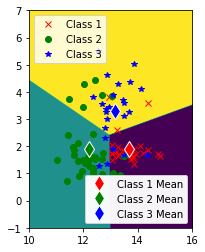

Below are the plots with decision regions and boundaries for the S_1 vs S_2 classes, S_1 vs S_3 classes, and the S_2 vs S_3 classes respectively.


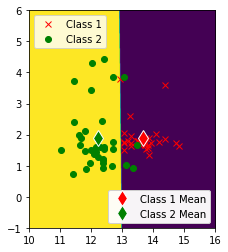

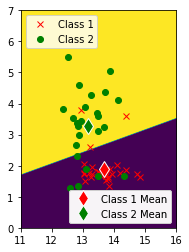

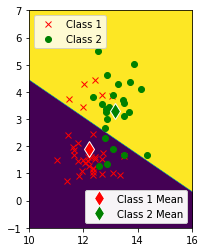

The training error rate on the wine dataset is: 0.8876404494382022
The testing error rate on the wine dataset is: 0.3258426966292135


In [44]:
wine_train_df = pd.read_csv('wine_train.csv', header=None)
wine_test_df = pd.read_csv('wine_test.csv', header=None)
wine_train = wine_train_df.to_numpy()
wine_test = wine_test_df.to_numpy()

X_train = wine_train[:, :2]
y_train = wine_train[:, 13]

X_test = wine_test[:, :2]
y_test = wine_test[:, 13]

train_accuracy, test_accuracy = nearest_mean_classifier(X_train, y_train, X_test, y_test, 3, cdist, True)
print("The training error rate on the wine dataset is: " + str(train_accuracy))
print("The testing error rate on the wine dataset is: " + str(test_accuracy))

### Below, I have included the plotDecBoundaries.py file with some minor changes. Please refer to that for more insight.